# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [1]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2
from ipywidgets import interact

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *

In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

## Load processed data

In [3]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print("\n\n\nThe vote dataframe is a " + str(votes.shape) + " table with senators as rows and vote positions as columns.")
display(votes.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
display(bill_descriptions.head(3))

# Separate votes into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.80, votes)

senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The vote dataframe is a (105, 284) table with senators as rows and vote positions as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,hr1-115-289-1,...,sconres3-115-22-1,sconres3-115-23-1,sconres3-115-24-1,sconres3-115-25-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The senators dataframe is a (105, 4) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,name
member_id,,,,
A000360,R,Lamar,Alexander,Lamar Alexander
B000575,R,Roy,Blunt,Roy Blunt
B000944,D,Sherrod,Brown,Sherrod Brown


## Load labels

## Building the similarity graph

Clustering coefficient: 0.5901256944114086


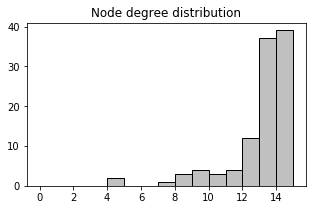

In [4]:
features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, .5), 15)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)

G = graphs.Graph(adjacency)
#G = reduction.graph_sparsify(G, 0.75)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

G_nx = nx.from_numpy_matrix(adjacency)

print("Clustering coefficient: " + str(nx.average_clustering(G_nx)))
plt.figure(figsize=(5,3))
plt.hist(adjacency.sum(1), bins=np.linspace(0,15,16), color='silver', lw=1, edgecolor='black')
plt.title("Node degree distribution")
plt.show()

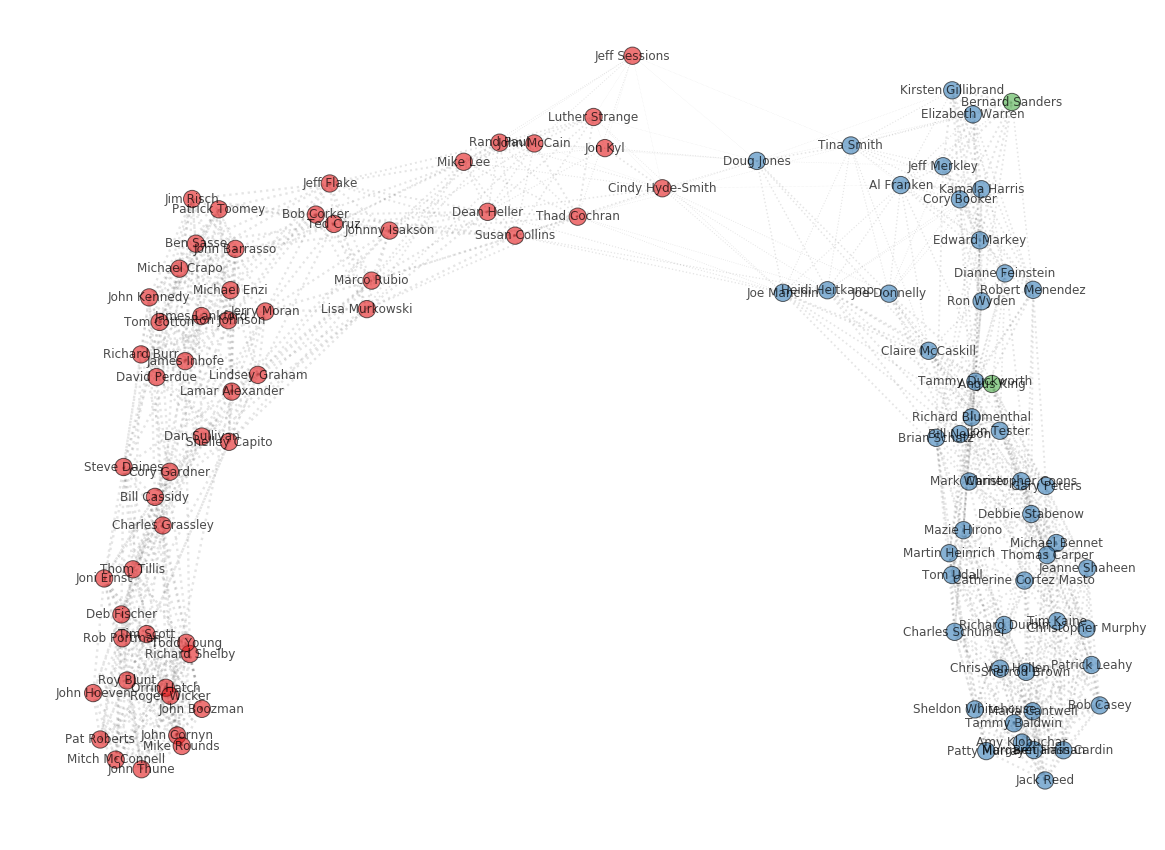

In [5]:
plot_signal(G.W.todense(), numerical_labels, labels=senators['name'], scale=[0,1])

## Clustering the bills

Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

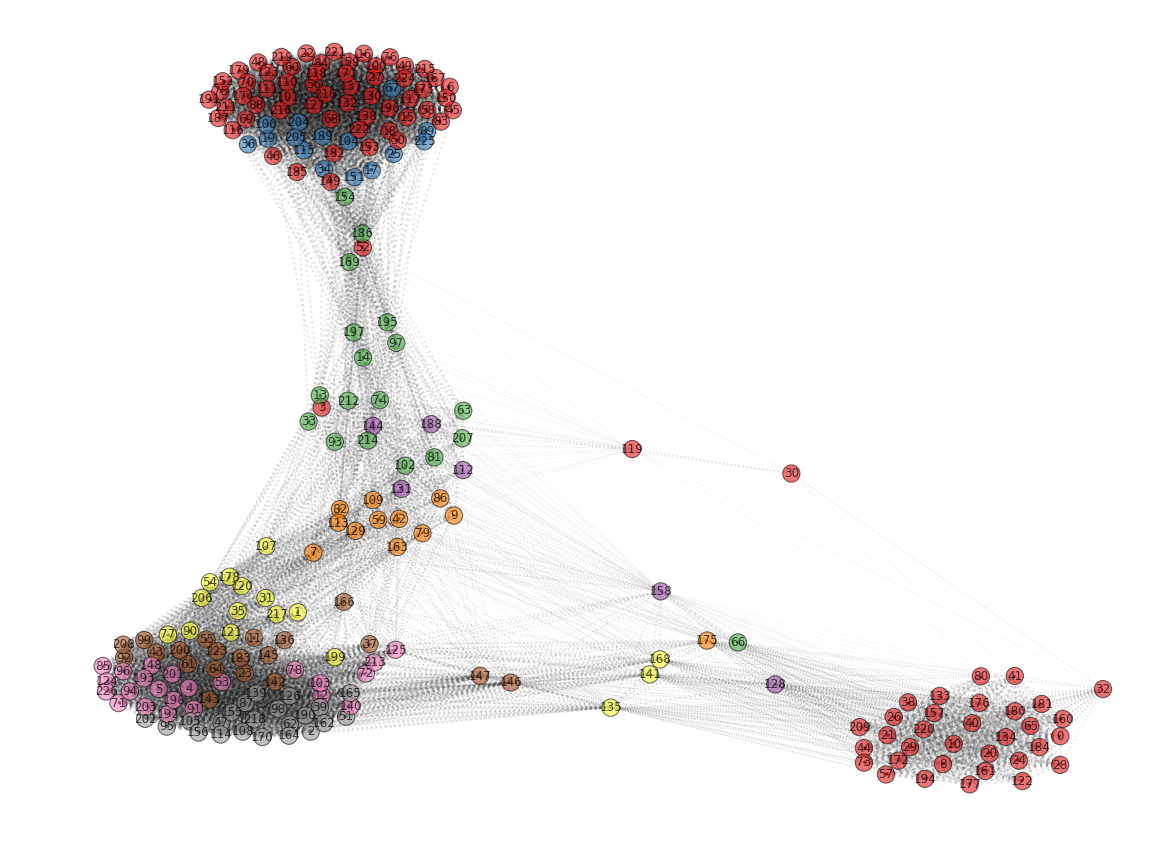

In [6]:
bill_cluster_count = 3

features_bills = [votes_train.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg,75),0.5)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)


G_nx = nx.from_numpy_matrix(adjacency_bills)

largest_component = max(nx.connected_components(G_nx), key=len)
s = G_nx.subgraph(largest_component)

G_bills = graphs.Graph(nx.to_numpy_matrix(s))
#G_bills = reduction.graph_sparsify(G_bills,0.33)

plot_signal(G_bills.W.todense(), votes_train.sum(0) / votes_train.shape[0], scale=[0,1])

### Method 1: Get biggest Variance

In [7]:
var = np.zeros(votes_train.shape[1])

for i in range(votes_train.shape[1]):
    a = votes_train.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([134, 116, 216], dtype=int64)

### Method 2: Get smallest number of neighbors

In [8]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([ 30, 119,   3], dtype=int64)

### Method 3: Get closest points of the centers of the cluster of the Bills

In [9]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()
embedding_dimension = 2
embedding = G_bills.U[:,1:1+embedding_dimension]
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    min_ = 1000;
    for i in range(embedding.shape[0]):
        dist = np.linalg.norm(embedding[i] - centers[j])
        if dist < min_:
            min_ = dist
            vote_repr[j] = i
            
vote_repr

array([166.,  28.,  25.])

### Getting selected bill description

In [10]:
selected_votes_unique_ids = votes_train.iloc[:, vote_repr].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING s89-115-102-1 ============== 

Roll call: 102
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00102

RELATED BILL INFORMATION

Bill title: A bill to amend title 46, United States Code, to exempt old vessels that only operate within inland waterways from the fire-retardant materials requirement if the owners of such vessels make annual structural alterations to at least 10 percent of the areas of the vessels that are not constructed of fire-retardant materials and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/s89

Short description: (This measure has not been amended since it was introduced. The expanded summary of the Senate reported version is repeated here.) (Sec.1)This bill revises the requirements for passenger vessels that are exempt from fire-retardant materials standards. Vessels in operation before January 1, 1968, that operate within inland wa

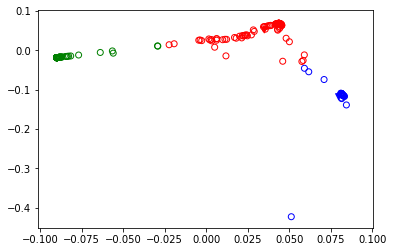

In [11]:
n = len(embedding)
colors = {0:'red',1:'blue',2:'green', 3:'orange'}

for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[clusters[i]])

plt.scatter(centers[:,0], centers[:,1], marker='v', color=list(colors.values())[:3])

### Method 4: Get the bills with biggest intracluster std

In [12]:
var = np.zeros(votes_train.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes.iloc[rep_indexes]
dem_data = votes.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([15, 29, 39], dtype=int64)

## Vote selection

['s89-115-102-1' 'hr1628-115-176-1' 'pn1383-115-85-2']


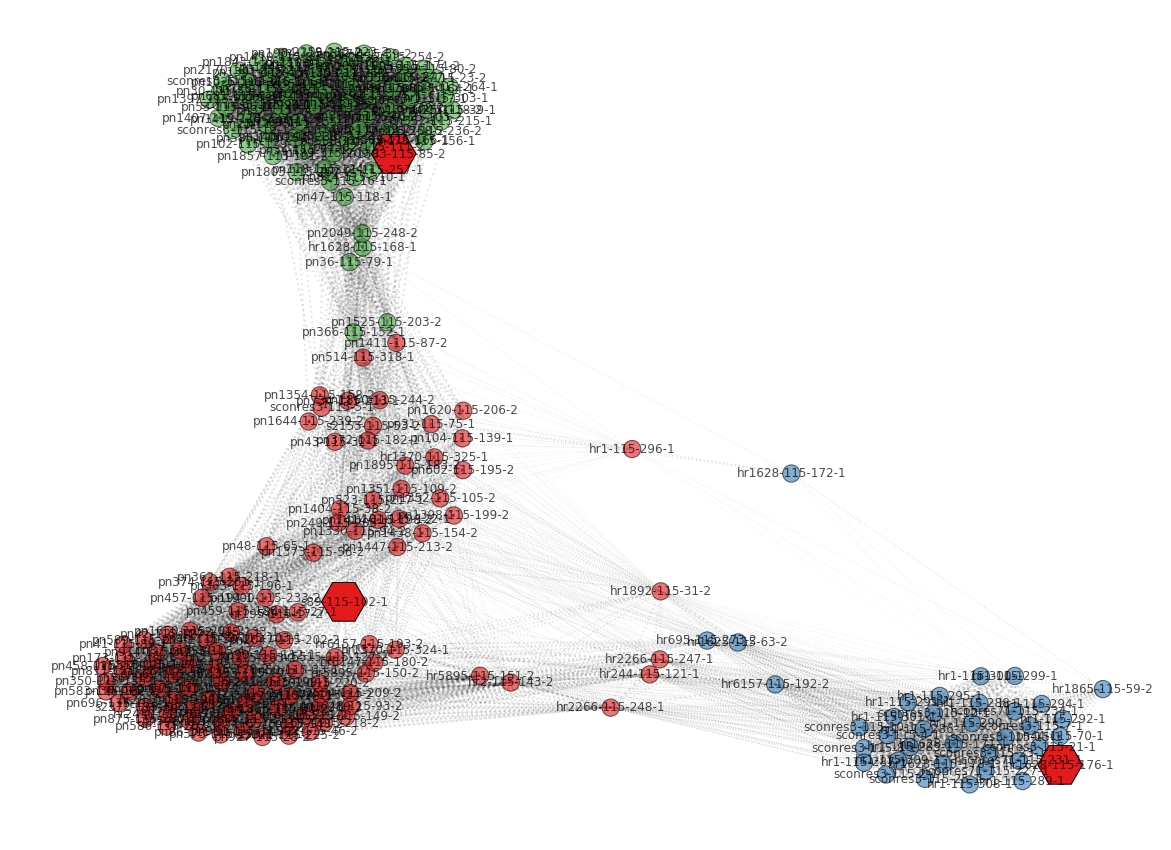

In [13]:

vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))

## Embedding you in the graph

In [14]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:3000px;  /* your desired max-height here */
}
</style>

In [29]:
def compute_similarity(senator_votes,your_votes):
    return euclidean_distance(senator_votes, your_votes)

against='Against'
pro='Pro'
neutral='Neutral'

G_extended = None

@interact(vote1=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote2=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote3=[(against,-1.0),(neutral,0.0),(pro,1.0)])
def choose(vote1=1.0,vote2=1.0,vote3=1.0):
    your_votes=[vote1,vote2,vote3]
    other_senators_vote = votes_train.values[:,vote_selection]
    similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote,your_votes)
    similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)

    top_similar = similarity_vector.argsort()[-3:][::-1]
    similar_senators = senators.iloc[top_similar]
    show_portraits(similar_senators)
    new_columns = np.append(similarity_vector, 0)

    n = len(adjacency)
    new_adjacency = np.zeros((n+1, n+1))
    new_adjacency[:n,:n] = adjacency
    new_adjacency[n,:] = new_columns
    new_adjacency[:,n] = new_columns

    global G_extended
    G_extended = graphs.Graph(new_adjacency)
    G_extended.set_coordinates('spring', seed=2018)
    G_extended.compute_fourier_basis()
    G_extended.compute_laplacian()
    G_extended.compute_differential_operator()
    
    new_labels = np.append(senators['name'].values, ['you'])
    
    plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])
    show_2D_embedding(G_extended.U[:,1:3], senators_party)
    show_political_spectrum(G_extended.U[:,1:3], n, colors, senators_party)

interactive(children=(Dropdown(description='vote1', index=2, options=(('Against', -1.0), ('Neutral', 0.0), ('P…

# Predicting votes based on votes from similar senators

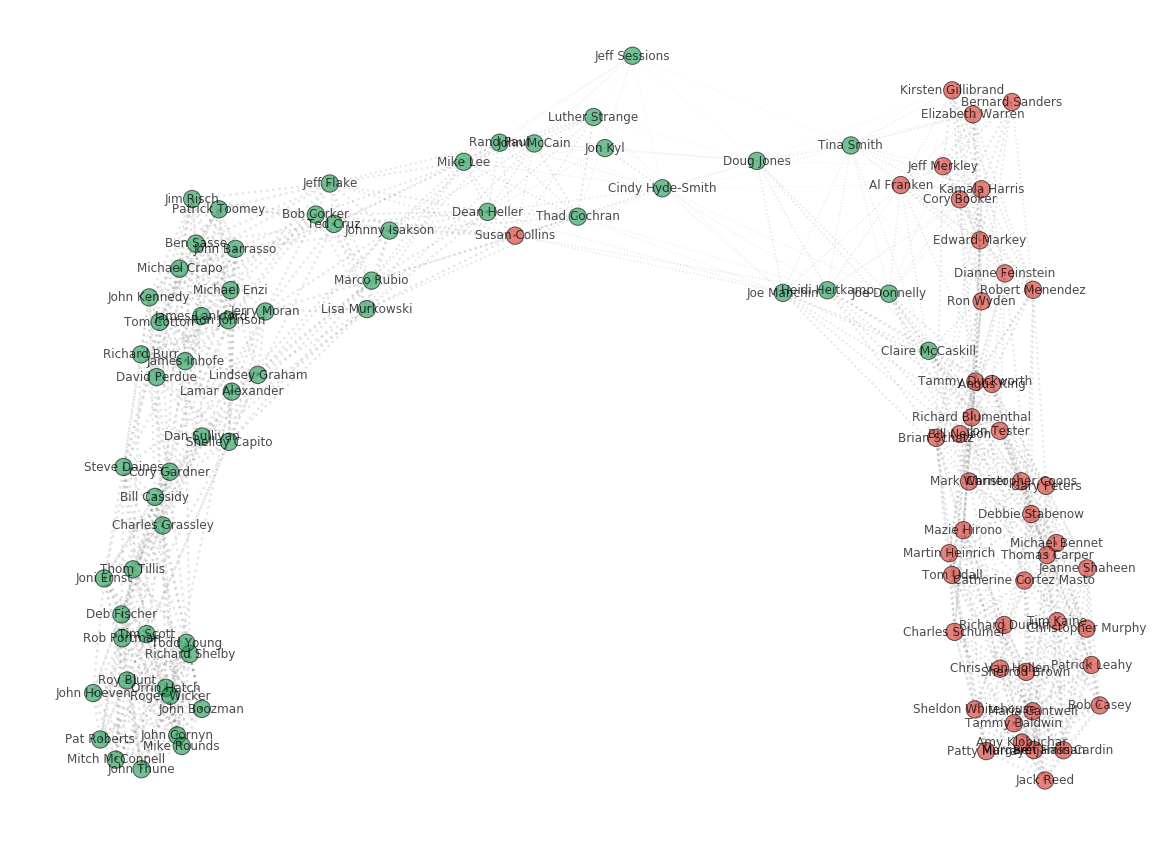

In [17]:
# Binarize labels
labels_bin = get_thresholded_values(votes_test.values[:,0], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

Error binarized: 0.4364357804719848
Accuracy binarized: 0.9523809523809523
Error non binarized: 0.530119736219288


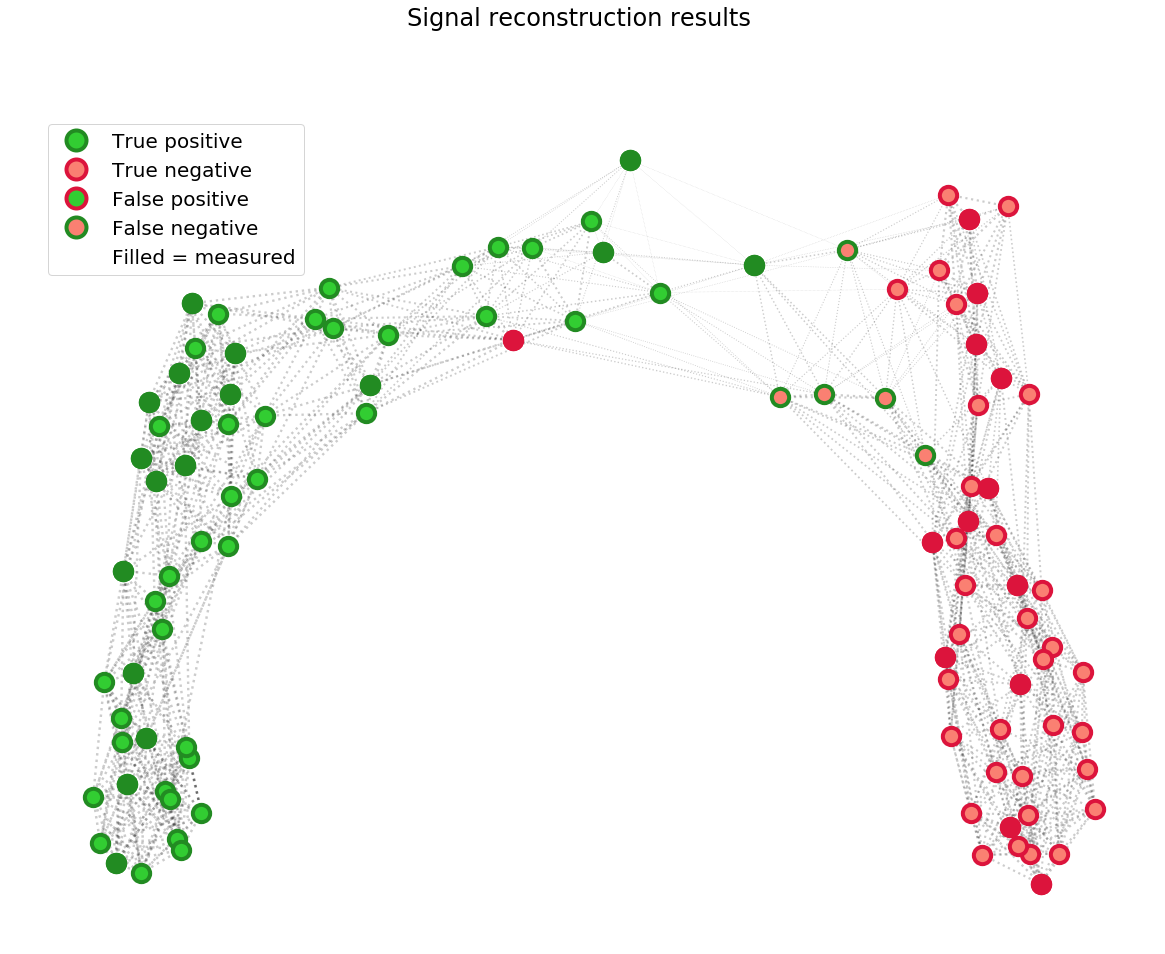

In [20]:
sol, sol_bin =  reconstruct_signal(G,w,labels_bin)
plot_prediction(G, sol_bin, labels_bin, w)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))

# What about you ?


In [30]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    w = np.append(np.ones(len(positions)), 0)    

    return reconstruct_signal(G, w, get_thresholded_values(bill_votes,0))

sol, sol_binarized = predict_your_votes(G_extended, votes_train.iloc[:,2])
print("On vote x you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")

On vote x you would have voted 1.0 (1.7703584781058779)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters

In [31]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

print(senators['name'].iloc[swing_senators])

predict_and_compare(G, votes_test, swing_senators)

member_id
C000567        Thad Cochran
C001035       Susan Collins
H001069      Heidi Heitkamp
H001079    Cindy Hyde-Smith
J000300          Doug Jones
K000352             Jon Kyl
M001183         Joe Manchin
S001141       Jeff Sessions
S001202      Luther Strange
S001203          Tina Smith
Name: name, dtype: object
Outcome accuracy: 1.0


([0.5238095238095238,
  1.0,
  1.0,
  0.7619047619047619,
  1.0,
  0.6,
  0.5523809523809524,
  1.0,
  0.9809523809523809,
  1.0,
  0.7333333333333333,
  0.7142857142857143,
  0.9809523809523809,
  0.7333333333333333,
  0.9523809523809523,
  0.8571428571428571,
  0.8095238095238095,
  0.8571428571428571,
  0.8666666666666667,
  1.0,
  0.638095238095238,
  0.8952380952380953,
  0.9619047619047619,
  0.6476190476190476,
  0.9142857142857143,
  0.6190476190476191,
  0.9809523809523809,
  0.6857142857142857,
  0.9904761904761905,
  0.9904761904761905,
  0.9619047619047619,
  0.9714285714285714,
  0.8857142857142857,
  1.0,
  0.9333333333333333,
  0.7142857142857143,
  0.5523809523809524,
  0.8952380952380953,
  0.7428571428571429,
  0.9714285714285714,
  0.8857142857142857,
  0.6095238095238096,
  0.8380952380952381,
  0.7523809523809524,
  0.7428571428571429,
  0.8380952380952381,
  0.780952380952381,
  0.9238095238095239,
  0.6,
  0.5619047619047619,
  0.8571428571428571,
  0.63809523809

~85% accuracy. How does that compare to the same number of senators but picked at random ? 

In [32]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
predict_and_compare(G, votes_test, random_senators)

                      name party
member_id                       
R000605        Mike Rounds     R
F000457         Al Franken     D
M001183        Joe Manchin     D
P000603          Rand Paul     R
C001098           Ted Cruz     R
C001070          Bob Casey     D
F000444         Jeff Flake     R
C000141    Benjamin Cardin     D
H001061        John Hoeven     R
B001267     Michael Bennet     D
Outcome accuracy: 0.8245614035087719


([0.9523809523809523,
  0.9714285714285714,
  1.0,
  0.9619047619047619,
  1.0,
  0.9523809523809523,
  0.9619047619047619,
  1.0,
  0.9523809523809523,
  1.0,
  0.7904761904761904,
  0.8857142857142857,
  0.9904761904761905,
  0.9523809523809523,
  0.9523809523809523,
  0.9809523809523809,
  0.819047619047619,
  0.9428571428571428,
  0.9714285714285714,
  0.9714285714285714,
  0.9047619047619048,
  0.8952380952380953,
  0.9523809523809523,
  0.8952380952380953,
  0.9142857142857143,
  0.8857142857142857,
  0.8952380952380953,
  0.7047619047619048,
  0.9238095238095239,
  0.9904761904761905,
  0.9619047619047619,
  0.9523809523809523,
  0.8857142857142857,
  1.0,
  0.9047619047619048,
  0.8476190476190476,
  0.9428571428571428,
  0.8952380952380953,
  0.7333333333333333,
  0.9714285714285714,
  0.8761904761904762,
  0.8857142857142857,
  0.9619047619047619,
  0.7619047619047619,
  0.8,
  0.8476190476190476,
  0.8666666666666667,
  0.9333333333333333,
  0.8761904761904762,
  0.990476190

Error binarized: 0.7302967433402215
Accuracy binarized: 0.8666666666666667
Error non binarized: 0.5717106299865128


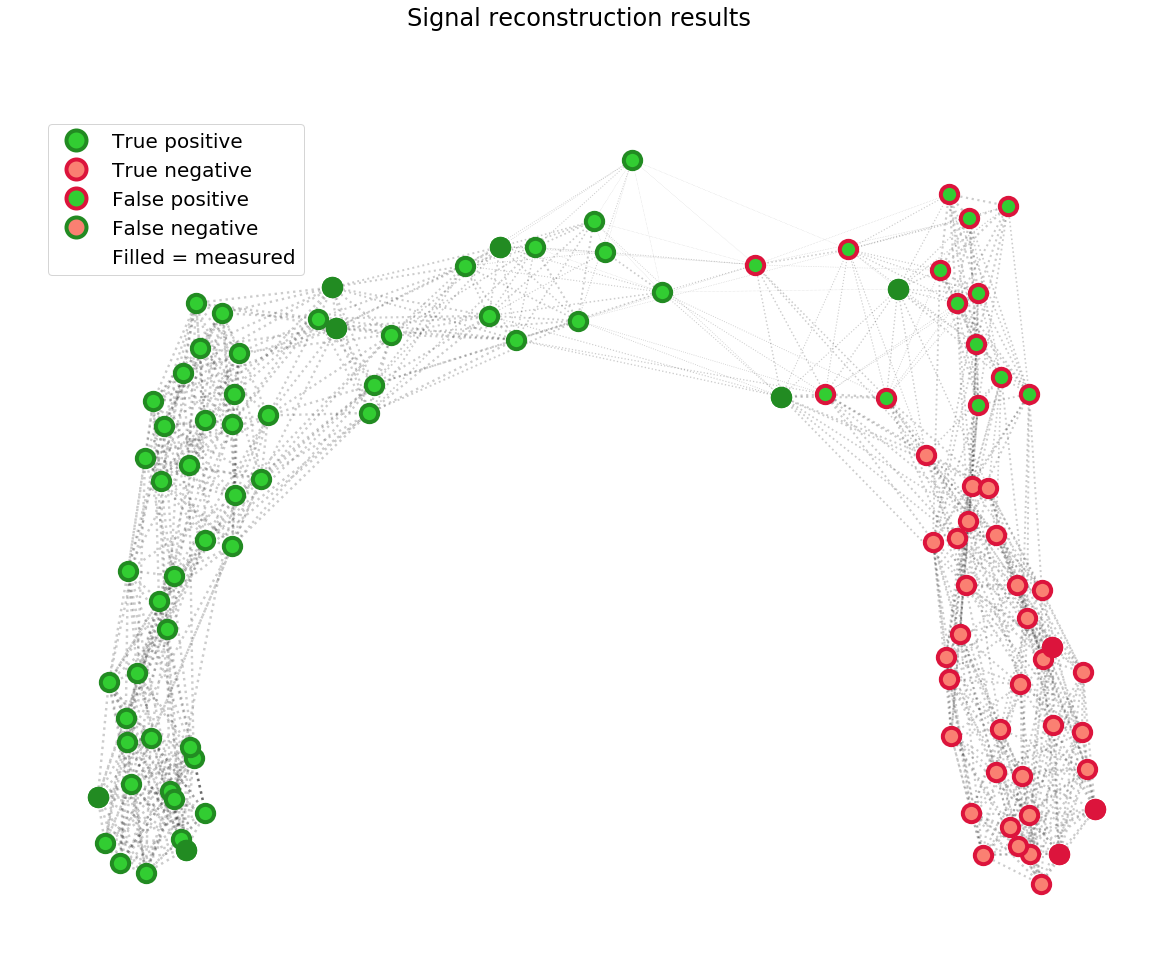

In [40]:
labels_bin = get_thresholded_values(votes_test.values[:,26], threshold=0)

mask = np.zeros(votes_test.shape[0])
mask[random_senators] = 1

sol, sol_bin =  reconstruct_signal(G,mask,labels_bin)
plot_prediction(G, sol_bin, labels_bin, mask)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))
